# BMI565 - Bioinformatics Programming & Scripting

## Week 10 - Image Analysis

** * Thanks to Ryan Swan for these materials.**

1. Introduction to Imaging
2. OpenCV
    * Opening Files
    * Converting between color scales
3. Clustering Image Data
    * Importing and formatting data
    * Performing clustering using scikit-learn
4. Classification with Image Data
    * Importing data and labels for classification
    * Performing classification using SVM in scikit-learn
5. Summary and References

#### Requirements

1. Python 2.7 or 3.5
2. `opencv (cv2)` module
3. `scikit-learn` module
4. `numpy` module
5. `matplotlib` module
6. Data Files
    - `./images/logo.jpg`
    - `./images/digits.png`

OpenCV should be installable using the `conda` command below, while all other packages should be included in the current Anaconda distribution.

    conda install opencv

** Note: when you install `opencv` using `conda`, the package manager may downgrade numpy and a couple other packages due to "dependency requirements". This may cause problems, so after installing `opencv` I recommend that you re-install numpy with `conda install numpy` (this shouldn't affect `opencv`).

## Imaging with OpenCV

In programming, there are many data types that we can manipulate and analyze. One of the most common of these data types is imaging data. Images are usually defined as a two-dimensional plot of intensity values. Each cell of the plot is a picture-element or "pixel". 

The method of defining a pixel varies depending on the imaging data. Black and white images can be thought of as a 2D array with values ranging from a minimum of 0, representing black, to a maximum value, representing white. The maximum value can vary based on how much fidelity is needed. Color images can be represented in a number of different ways, with three dimensions (RGB = Red, Green, Blue) or four dimensions (CMYK = cyan, magenta, yellow, black), and often include an extra value representing the luminance of the pixel. It is also possible that pixels may represent data that is not visible to the human eye, like X-ray, gamma ray, or infrared data.

## OpenCV

The OpenCV package in python provides a number of tools to manipulate imaging data. Primarily the tools provided are used to open and convert imaging formats so that they can be analyzed and processed. Images are stored as numpy ndarrays, which represent multidimensional arrays of fixed size.

## Opening and Viewing Images

Our first order of business is to open an image file and inspect it. The "logo.jpg" file contains the OHSU logo in the compressed JPEG format.

[http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html)

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [4]:
## Read the image (1 = color, 0 = grayscale, -1 = unchanged w/ alpha channel)
img = cv2.imread('./images/logo.jpg', 4)

Inspect the img object. We can see from this that it is an array of values, most of which are [255, 255, 255]. This corresponds to a white pixel, where red, green, and blue values are all at the maximum intensity of 255. This tells us that the image is in 8-bit format, which allows for 2^8 levels of intensity (0-255).

In [5]:
## Image size
img.shape

(622, 900, 3)

In [6]:
## The image data
img[0:10,0]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

Now that we've opened the image we can view it with `matplotlib`. 

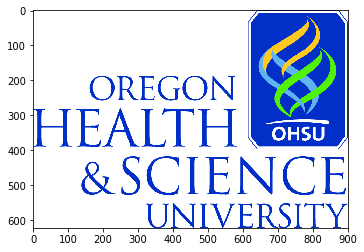

In [7]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Clustering On Imaging Data

Now that we have an image as a python data type we are free to perform any number of calculations on the image. One useful piece of information is what the most common colors in the image are. We can think about each pixel as a point in three dimensional space, where the colors red, blue, and green are mapped to spacial values. In this spacial context, we can use clustering to find the areas in the space of colors where most pixels are located.

The first thing we need to do is to convert our image from a two-dimensional array into a one-dimensional list of pixels. For this analysis, we are only interested in the color data and not in the location of each pixel within the image.

Reshape and shape are methods of the ndarray class. Shape gives the dimensions of an n-dimensional array as a tuple with n positions. Reshape takes a tuple with n positions and reorganizes the array to fit that specification.

Here we take the first two dimensions of the array (representing the 2d location information) and flatten it into a column of values where each row contains a single pixel's color intensity information.

In [8]:
## reshape the image to be a list of pixels
img = img.reshape((img.shape[0] * img.shape[1], 3))

In [9]:
img.shape

(559800, 3)

In [10]:
img[0:5]

array([[255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255],
       [255, 255, 255]], dtype=uint8)

We are now ready to import the KMeans method from scikit-learn. We define that we want a model with 5 clusters. This will return the five "neighborhoods" where most pixel values are centered. Theoretically this should fit our image well, since there are exactly five colors in the image.

In [11]:
## Do clustering
from sklearn.cluster import KMeans

clt = KMeans(n_clusters = 5)
clt.fit(img)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [12]:
## View the cluster centers
clt.cluster_centers_

array([[254.89792122, 254.76335912, 254.72889201],
       [234.17173728, 168.34987205, 122.89707137],
       [  9.35204856, 238.80918058,  79.77314112],
       [ 33.98472538, 200.29493013, 251.93532662],
       [199.245939  ,  48.6009653 ,   3.05893104]])

We will now define two functions that will help us analyze and display the data. The first is a function to create a histogram that represents the number of pixels associated with each cluster center. The function uses numpy (imported above).

In [13]:
def centroid_histogram(clt):
    ## grab the number of different clusters and create a histogram
    ## based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
 
    ## normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
 
    ## return the histogram
    return hist

The second function uses the histogram to create a bar that displays the proportion of the image represented by each cluster centroid. In essence, we use the histogram percentage to populate a 50x300 pixel bar with color information. We use the rectangle method to reorganize our bar into the correct display format.

In [14]:
def plot_colors(hist, centroids):
    ## initialize the bar chart representing the relative frequency
    ## of each of the colors
    bar = np.zeros((50, 300, 3), dtype = "uint8")
    startX = 0
 
    ## loop over the percentage of each cluster and the color of
    ## each cluster
    for (percent, color) in zip(hist, centroids):
        ## plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
            color.astype("uint8").tolist(), -1)
        startX = endX
    
    ## Convert back to RGB (implicit conversion takes place when clustering)
    bar = cv2.cvtColor(bar, cv2.COLOR_BGR2RGB)
    ## return the bar chart
    return bar

We now have all the necessary tools to display our color plot of the OHSU logo image.

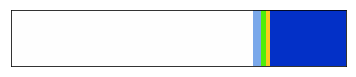

In [15]:
## build a histogram of clusters and then create a figure
## representing the number of pixels labeled to each color
hist = centroid_histogram(clt)
bar = plot_colors(hist, clt.cluster_centers_)
 
## show our color bart
plt.figure()
plt.axis("on")
## Remove the ticks and labels from the plot
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.imshow(bar)

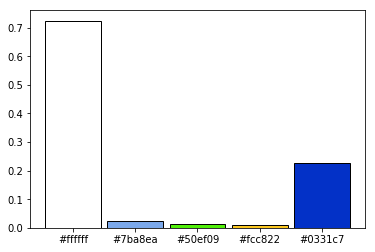

In [16]:
## We can also create a bar plot to represent the same info
import matplotlib as mpl
## Convert the colors from GBR to RGB and scale the values
colors = [c[::-1]/255 for c in clt.cluster_centers_]
plt.bar(np.arange(1,6), hist, width=0.9, color=colors, edgecolor='black')
## Create x-axis ticks and labels (converting RGB colors to hexadecimal)
ticks1 = plt.xticks(np.arange(1,6), [mpl.colors.rgb2hex(x) for x in colors])

The resulting plots capture the five major colors used in the image and their relative frequencies. As we can see, the image is mostly white and blue with a sprinkling of other colors mixed in. If we wish to know the exact proportions it is possible to use the histogram object in order to find these.

## Classification of Digits from Imaging Data Using an SVM

While clustering is a useful way of describing data, it is not always the best tool for classification. In cases where we have labeled data, a supervised learning method is often preferable. One canonical example is the recognition of digits from handwriting. 

As before, our first task is to open the file and get the image into a format that makes sense for our purposes.

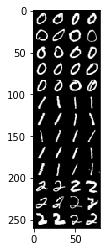

In [17]:
## Open the image (remember the 0 denotes that this is a grayscale image)
img2 = cv2.imread('./images/digits.png',0)

## Show a portion of the image
numrows = 260
numcols = 80
plt.imshow(img2[:numrows,:numcols], cmap='gray')

As we can see, the image in this case is one large image containing many examples of handwritten digits. In order for us to analyze the image we must first restructure the data so that it is a single column where each row contains the intensity values for a single handwritten digit. 

The ndarray contains two additional methods that allow us to perform this process. The hsplit method splits an image on the horizontal axis while the vsplit method splits an image along the vertical axis. Once we determine that the data is arranged with 100 columns and 50 rows, all evenly spaced, we can write a list comprehension that quickly performs this rearrangement.

In [18]:
## The image size
img2.shape

(1000, 2000)

In [19]:
## The image data (it's gray-scale this time)
img2[0:10,0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [20]:
## This tells OpenCV that the image is arranged in 50 rows and 100 columns (5000 digits)
cells = [np.hsplit(row,100) for row in np.vsplit(img2,50)]

## Make an array from the data
x = np.array(cells)

In [21]:
## Now each digit (N=5000) is a block of 20x20 pixels
x.shape

(50, 100, 20, 20)

The cells object now contains a 50x100 array where each cell contains a handwritten digit (20x20 pixels). We will need to reshape the data further, but while it is in a convenient format, we can define our training and test sets by splitting the array in half.

In [22]:
## The first digit
print(x[0,0])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   9  33   9   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   0  41 177 249 178  29   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0  33 198 255 240 255 107   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   1  70 199 255 255 197 154 253  98   0   0
    0   0]
 [  0   0   0   0   0   0   0  45 238 255 205 224 222  83 224 128   0   0
    0   0]
 [  0   0   0   0   0   0  25 202 255 193  40  99  54   0 190 197  16   0
    0   0]
 [  0   0   0   0   0  20 163 246 152  72   0   0   0   0 184 252  74   0
    0   0]
 [  0   0   0   0   0  97 255 118   0   1   0   0   0   0 184 255  82   0
    0   0]
 [  0   0   0   0  20 218 216  17   0   0   0   0   0   0 183 255  78   0
    0   0]
 [  0   0   0   0  67 255 138   0   0   0   0   0   0  24 215 188

In [23]:
## Now we prepare training data and test data
## Takes the first 50 columns and puts them into the training set
train = x[:,:50]

## reshape takes these and makes them 2500 rows and 400 (20x20) columns
## giving -1 as one of the dimensions will tell numpy to determine the value 
## based on the length of the array and the other dimensions given
train = train.reshape(-1,400)

## the astype function converts to the float type that the clustering method is expecting
train = train.astype(np.float32) ## Size = (2500,400)

## We do the same for the test set
test = x[:,50:100]
test = test.reshape(-1,400)
test = test.astype(np.float32) ## Size = (2500,400)

In order to train our classifier, we need to have labeled data. From the structure of our data, we know that each number is in a group, so we can specify a list of values to fit the data.

In [24]:
## Create labels for train and test data
## We have numbers 0 to 10...
k = np.arange(10)
## In sets of 250
## We create the labels as a 1D array
train_labels = np.repeat(k,250)

## our test labels are the same as our training labels, so we can copy this over
test_labels = train_labels.copy()

We're now ready to move on to peforming our model fitting. We use a support vector machine (SVM) which considers each pixel intensity value in the digit as a dimension in euclidian space. The SVM then attempts to draw an optimized boundary between points of different classes in order to classify them into groups. Since we have 10 classes (numbers 0-9) it will divide them into ten categories.

We also load the metrics method, which contains reports that work with scikit-learn's classifiers in order to provide information about the performance of the classifier. Here we use the `classification_report` and `confusion_matrix` methods.

In [25]:
## Import modules from scikit-learn
from sklearn import svm, metrics

## Train an SVM classifier
classifier = svm.LinearSVC()
classifier.fit(train, train_labels)

## Predict the classes of the test set
predicted = classifier.predict(test)
print("Classification report for classifier %s:\n\n%s\n"
      % (classifier, metrics.classification_report(test_labels, predicted)))

Classification report for classifier LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0):

             precision    recall  f1-score   support

          0       0.92      0.93      0.92       250
          1       0.95      0.93      0.94       250
          2       0.83      0.80      0.82       250
          3       0.76      0.78      0.77       250
          4       0.89      0.78      0.83       250
          5       0.80      0.80      0.80       250
          6       0.89      0.92      0.91       250
          7       0.85      0.87      0.86       250
          8       0.75      0.72      0.74       250
          9       0.72      0.80      0.76       250

avg / total       0.84      0.83      0.83      2500




In [26]:
## View a confusion matrix of the classification results
print("Confusion matrix:\n%s" % metrics.confusion_matrix(test_labels, predicted))

Confusion matrix:
[[232   0   6   3   0   1   4   0   4   0]
 [  0 232   1   5   0   1   0   1  10   0]
 [  5   3 201   9   5   3   5   6  11   2]
 [  2   0   8 196   1  18   1   4   9  11]
 [  2   3   1   5 194   3   8   3   6  25]
 [  3   1   3  18   2 200   3   0  10  10]
 [  2   1   7   1   0   5 231   0   2   1]
 [  0   1   3   3   3   2   0 217   2  19]
 [  2   3  10  16   5  14   6   4 181   9]
 [  5   0   2   3   9   2   2  21   5 201]]


From this we can see that our classifier (sort of) worked. We get good precision, showing that our method does a decent job of minimizing false positives. We can also see that our recall is relatively high, meaning that it calls fairly few false negatives. From our graph it seems the numerals 3, 8, and 9 are the hardest to predict, while 0, 1, and 6 are the easiest.

## Summary

This lecture gives two specific examples of ways in which imaging data can be manipulated to draw interesting conclusions. The field of imaging is much larger than presented here, however, and python has many packages that perform various imaging tasks. Some common tasks include image enhancement, image filtering, and image segmentation (the isolation of various features of interest based on their attributes). While the packages necessary to do such manipulations may be different, the underlying workflow remains essentially the same (reading the image data, reformatting the image data, and using that data in order to find the features of interest).

## In-class Exercises


In [27]:
## Find an image of your own and perform the clustering process on it. 
## Try modifying the number of clusters used. What do you notice?


In [28]:
## The following function normalizes imaging data based on the image's 
## second order moments. Use this function to process the training and
## test sets of digits then rerun the analysis. Does this improve the
## classifier's performance?
##
## Deskew Explanation and Code: 
## http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_ml/py_svm/py_svm_opencv/py_svm_opencv.html#svm-opencv
affine_flags = cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR

def deskew(img, SZ=20): ## SZ is the size of each digit (20x20)
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img


## Sources

- [OpenCV Tutorial](http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_gui/py_image_display/py_image_display.html)
- [Image Clustering Tutorial](http://www.pyimagesearch.com/2014/05/26/opencv-python-k-means-color-clustering/)
- [OpenCV Digit Classification Tutorial](http://opencv-python-tutroals.readthedocs.org/en/latest/py_tutorials/py_ml/py_knn/py_knn_opencv/py_knn_opencv.html)

#### Last Updated: 9-Oct-2018